In [2]:
from skfda.datasets import fetch_phoneme
from skfda.misc.covariances import Gaussian, Exponential, Polynomial
from skfda.preprocessing.dim_reduction import FDM
from skfda.representation import FDataGrid

from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

import numpy as np

from sklearn.model_selection import train_test_split

random_state = np.random.RandomState(seed=258852);

In [3]:
import matplotlib as mpl
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = ['Computer Modern Roman']

fs = 18

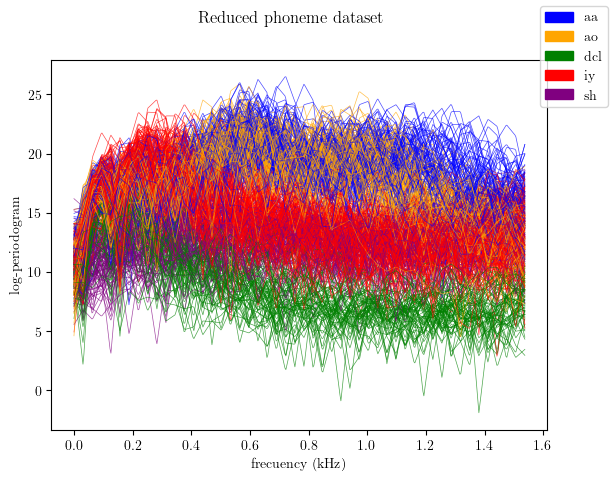

In [4]:
data, labels = fetch_phoneme(return_X_y=True, as_frame=True)
n_points, n_samples = 50, 500

random_choice = sorted(
    random_state.choice(data.shape[0], size=n_samples, replace=False),
)

# Create funcional data preprocessed object
fd = data.iloc[random_choice, 0].values
fd_phoneme = FDataGrid(
    grid_points=fd.grid_points[0][:n_points],
    data_matrix=fd.data_matrix[:, :n_points],
    dataset_name="Reduced phoneme dataset",
    argument_names=("frecuency (kHz)",),
    coordinate_names=("log-periodogram",),
)

# Define y label
encoder = LabelEncoder()
y = encoder.fit_transform(labels)[random_choice]
labels = encoder.inverse_transform(y)

target = np.unique(labels)
colors = ["blue", "orange", "green", "red", "purple"]
colors_phoneme = dict(zip(target, colors))
cmap = ListedColormap(colors)
dark_cmap = ListedColormap(["#5278b8", "#b88652", "#527852", "#b85252", "#845184"])

fd_phoneme.plot(
    group=labels,
    group_colors=colors_phoneme,
    linewidth=0.5,
    alpha=0.7,
    legend=True,
)

test_size = 0.2
n_train, n_test = int((1 - test_size) * n_samples), int(test_size * n_samples)
fd_train, fd_test, y_train, y_test = train_test_split(
    fd_phoneme, y, test_size=test_size, random_state=random_state,
)

In [5]:
n_steps = 1
fdm = FDM(kernel=Gaussian(length_scale=1.0), n_steps=n_steps)
knn = KNeighborsClassifier(n_neighbors=5)
pipe = Pipeline([
    ('dim_red', fdm),
    ('classification', knn),
])

# Example of use
pipe.fit(fd_train, y_train)
predictions = pipe.predict(fd_test)
accuracy = pipe.score(fd_test, y_test)
print('Accuracy of %f' % accuracy)

Accuracy of 0.820000


In [6]:
param_grid = {
    'dim_red__kernel': [
        Gaussian(length_scale=0.5),
        Gaussian(length_scale=1),
        Gaussian(length_scale=2),
        Gaussian(length_scale=3),
        Gaussian(length_scale=4),
        Gaussian(length_scale=6),
        Gaussian(length_scale=10.0),
        Exponential(length_scale=0.5),
        Exponential(length_scale=1),
        Exponential(length_scale=2),
        Exponential(length_scale=3),
        Exponential(length_scale=4),
        Exponential(length_scale=6),
        Exponential(length_scale=10.0),
    ],
    'dim_red__alpha': [0, 0.25, 0.5, 0.75, 1.0],
    'classification__n_neighbors': [3, 5, 7, 11, 19],
}

search = GridSearchCV(pipe, param_grid, n_jobs=2)
search.fit(fd_train, y_train)


GridSearchCV(estimator=Pipeline(steps=[('dim_red',
                                        FDM(kernel=skfda.misc.covariances.Gaussian(variance=1, length_scale=1.0))),
                                       ('classification',
                                        KNeighborsClassifier())]),
             n_jobs=2,
             param_grid={'classification__n_neighbors': [3, 5, 7, 11, 19],
                         'dim_red__alpha': [0, 0.25, 0.5, 0.75, 1.0],
                         'dim_red__kernel': [skfda.misc.covariances.Gaussian(variance=1, length_scale=0.5...
                                             skfda.misc.covariances.Exponential(variance=1, length_scale=1),
                                             skfda.misc.covariances.Exponential(variance=1, length_scale=2),
                                             skfda.misc.covariances.Exponential(variance=1, length_scale=3),
                                             skfda.misc.covariances.Exponential(variance=1, length_scale=4),
                                             skfda.misc.covariances.Exponential(variance=1, length_scale=6),
                                             skfda.misc.covariances.Exponential(variance=1, length_scale=10.0)]})

In [7]:
print(search.best_params_)

# Save fined tuned parameters
optimum_alpha = search.best_params_['dim_red__alpha']
optimum_kernel = search.best_params_['dim_red__kernel']
optimum_neighbors = search.best_params_['classification__n_neighbors']
print(
    'Obtained accuracy of %.4f with an' % search.best_score_,
    'alpha parameter of %.2f and length scale of' % optimum_alpha,
    'the kernel of %.2f.' % optimum_kernel.length_scale,
)

{'classification__n_neighbors': 11, 'dim_red__alpha': 0, 'dim_red__kernel': skfda.misc.covariances.Gaussian(variance=1, length_scale=1)}
Obtained accuracy of 0.9000 with an alpha parameter of 0.00 and length scale of the kernel of 1.00.


In [8]:
# Divide the training dataset into equal pieces
partitions = 20
indices = random_state.permutation(n_train)
split_indices = np.linspace(0, n_train, partitions + 1)[1:]

knn = KNeighborsClassifier(n_neighbors=optimum_neighbors)
fdm = FDM(alpha=optimum_alpha, kernel=optimum_kernel, n_steps=n_steps)
pipe = Pipeline([
    ('dim_red', fdm),
    ('classification', knn),
])
accuracies_test, accuracies_train = [], []

for index in split_indices:
    subset_indices = indices[:int(index)]
    fd_train_subset = fd_train[subset_indices]
    y_train_subset = y_train[subset_indices]

    pipe.fit(fd_train_subset, y_train_subset)
    accuracies_test.append(pipe.score(fd_test, y_test))
    accuracies_train.append(pipe.score(fd_train_subset, y_train_subset))

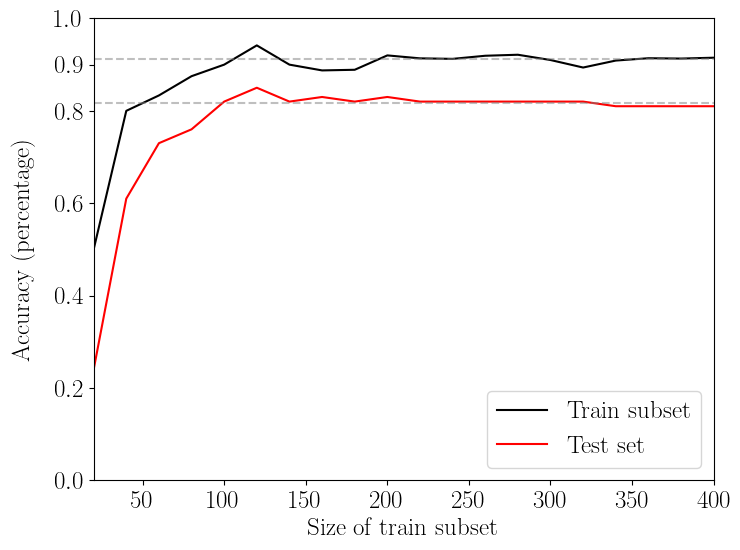

In [9]:
plt.figure(figsize=(8, 6))
plt.plot(split_indices, accuracies_train, label="Train subset", color = "black")
plt.plot(split_indices, accuracies_test, label="Test set", color="red")
plt.legend(fontsize=fs, loc="lower right")
# plt.title('Accuracies when predicting test set / train subset.')
plt.tick_params(axis='both', which='major', labelsize=fs)
plt.xlabel('Size of train subset', fontsize=fs)
plt.ylabel('Accuracy (percentage)', fontsize=fs, labelpad=14)
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 0.9, 1.0])
plt.axhline(y=np.mean(accuracies_test[9:]), linestyle='--', linewidth=1.5, color='gray', alpha=0.5)
plt.axhline(y=np.mean(accuracies_train[9:]), linestyle='--', linewidth=1.5, color='gray', alpha=0.5)
plt.xlim(20, 400)
plt.show()

Accuracy of 0.810000


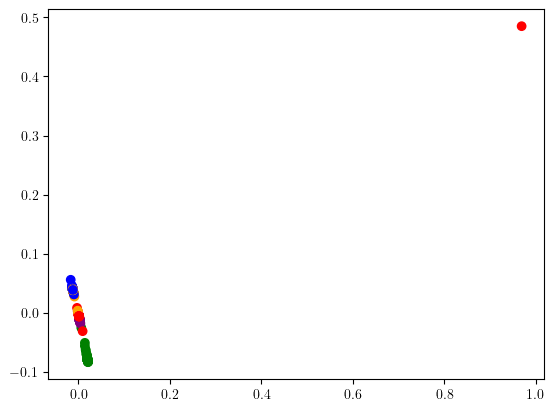

In [10]:
fdm = FDM(alpha=optimum_alpha, kernel=optimum_kernel, n_steps=n_steps)

knn = KNeighborsClassifier(n_neighbors=optimum_neighbors)
pipe = Pipeline([
    ('dim_red', fdm),
    ('classification', knn),
])

predictions = pipe.fit(fd_train, y_train).predict(fd_test)
accuracy = pipe.score(fd_test, y_test)
print('Accuracy of %f' % accuracy)

embedding = fdm.fit_transform(fd_phoneme)

plt.scatter(
    embedding[:, 0], embedding[:, 1],
    c=y, cmap=cmap,
)
plt.show()

### Let's use $length\_scale = 4.0$ for visual interpretability.

In [11]:
print(optimum_alpha, n_steps)

0 1


Accuracy of 0.670000


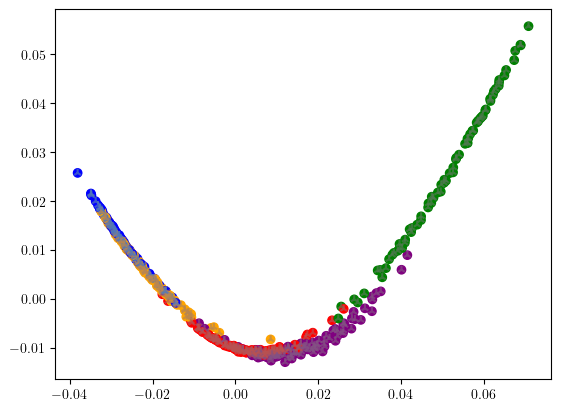

In [12]:
length_scale = 4.0
fdm = FDM(alpha=optimum_alpha, kernel=Gaussian(length_scale=length_scale),n_steps=n_steps)

knn = KNeighborsClassifier(n_neighbors=optimum_neighbors)
pipe = Pipeline([
    ('dim_red', fdm),
    ('classification', knn),
])

predictions = pipe.fit(fd_train, y_train).predict(fd_test)
accuracy = pipe.score(fd_test, y_test)
print('Accuracy of %f' % accuracy)

fd_phoneme_ordered = fd_train.concatenate(fd_test)
y_ordered = np.concatenate((y_train, y_test))
true_embedding = fdm.fit_transform(fd_phoneme_ordered)
pred_embedding = fdm.transform(fd_phoneme_ordered)

plt.scatter(
    pred_embedding[:, 0], pred_embedding[:, 1],
    c=y_ordered, cmap=cmap
)
plt.scatter(
    true_embedding[:, 0], true_embedding[:, 1],
    c=y_ordered, cmap=dark_cmap, alpha=0.7, marker="2",
)
plt.show()

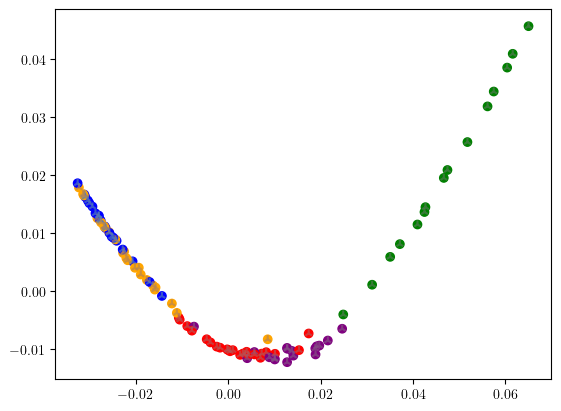

In [13]:
# Lets see the comparison between the prediction and the true embedding of the test set
test_pred_embedding = fdm.transform(fd_test)
test_true_embedding = true_embedding[n_train:]

plt.scatter(
    test_pred_embedding[:, 0], test_pred_embedding[:, 1],
    c=y_test, cmap=cmap,
)
plt.scatter(
    test_true_embedding[:, 0], test_true_embedding[:, 1],
    c=y_test, cmap=dark_cmap, alpha=0.7, marker="2",
)

plt.show()

In [14]:
# Divide the training dataset into equal pieces
partitions = 20
indices = random_state.permutation(n_train)
split_indices = np.linspace(0, n_train, partitions + 1)[1:]

knn = KNeighborsClassifier(n_neighbors=optimum_neighbors)
fdm = FDM(alpha=optimum_alpha, kernel=optimum_kernel, n_steps=n_steps)
pipe = Pipeline([
    ('dim_red', fdm),
    ('classification', knn),
])
accuracies = []

for index in split_indices:
    subset_indices = indices[:int(index)]
    fd_train_subset = fd_train[subset_indices]
    y_train_subset = y_train[subset_indices]

    pipe.fit(fd_train_subset, y_train_subset).predict(fd_test)
    accuracies.append(pipe.score(fd_test, y_test))

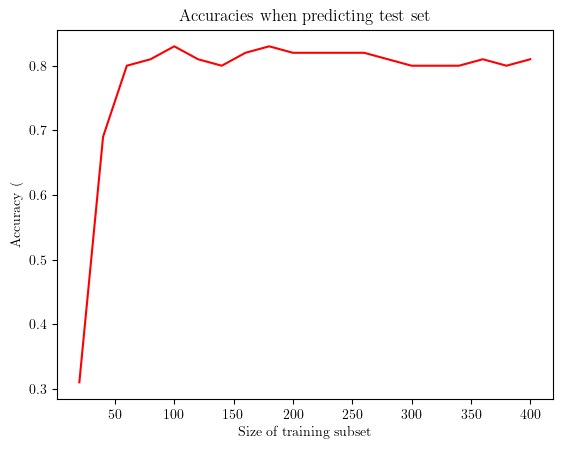

In [15]:
plt.plot(split_indices, accuracies, 'red')
plt.title('Accuracies when predicting test set')
plt.xlabel('Size of training subset')
plt.ylabel('Accuracy (%)');

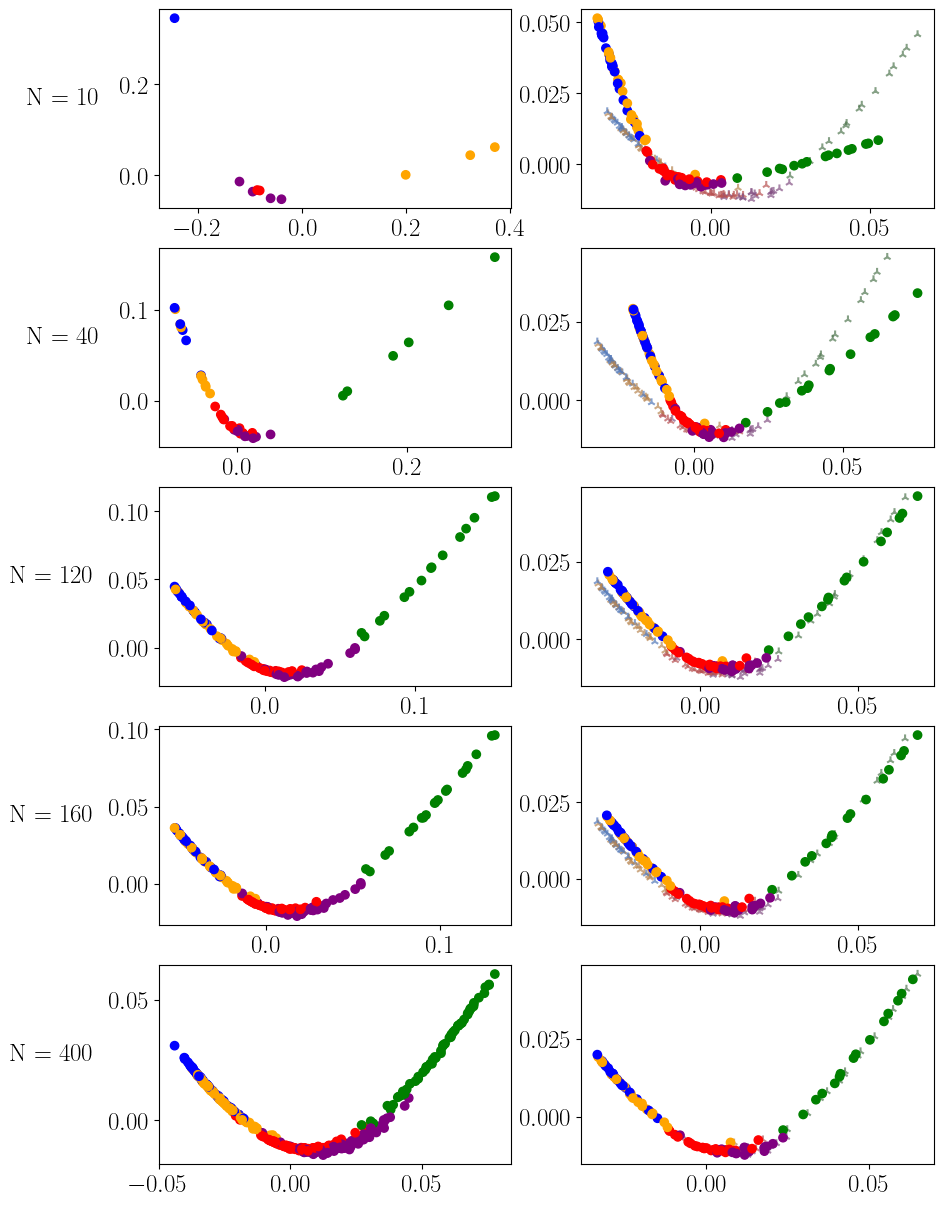

In [16]:

# Divide the training dataset into equal pieces
# N = 400 implies training over the whole training set
split_indices = [10, 40, 120, 160, 400]

fig, axs = plt.subplots(5, 2, figsize=(10, 5*3))
k = 0

for index in split_indices:
    subset_indices = indices[:int(index)]
    fd_train_subset = fd_train[subset_indices]
    y_train_subset = y_train[subset_indices]
    
    fdm = FDM(alpha=optimum_alpha, kernel=Gaussian(length_scale=length_scale))

    train_subset_embedding = fdm.fit_transform(fd_train_subset)
    test_embedding = fdm.fit(fd_train_subset).transform(fd_test)

    # axs[0].set_title('Diffusion coordinates of the %d training curves.' % index)
    axs[k][0].scatter(
        train_subset_embedding[:, 0], train_subset_embedding[:, 1],
        c=y_train_subset, cmap=cmap,
    )
    axs[k][0].tick_params(axis='both', which='major', labelsize=fs)
    axs[k][0].set_ylabel('N = ' + str(index), fontsize=fs, rotation=0, labelpad=40)


    # axs[1].set_title('Predicted diffusion coordinates of the test set.')
    axs[k][1].scatter(
        # test_true_embedding[:, 0], test_true_embedding[:, 1],
        # np.sqrt(500/index) * test_true_embedding[:, 0], np.sqrt(500/index) * test_true_embedding[:, 1],
        test_true_embedding[:, 0], test_true_embedding[:, 1],
        c=y_test, cmap=dark_cmap, alpha=0.7, marker ="2",
    )
    axs[k][1].scatter(
        np.sqrt(index/500) * test_embedding[:, 0], np.sqrt(index/500) * test_embedding[:, 1],
        c=y_test, cmap=cmap,
    )
    axs[k][1].tick_params(axis='both', which='major', labelsize=fs)
    k = k + 1
plt.show()

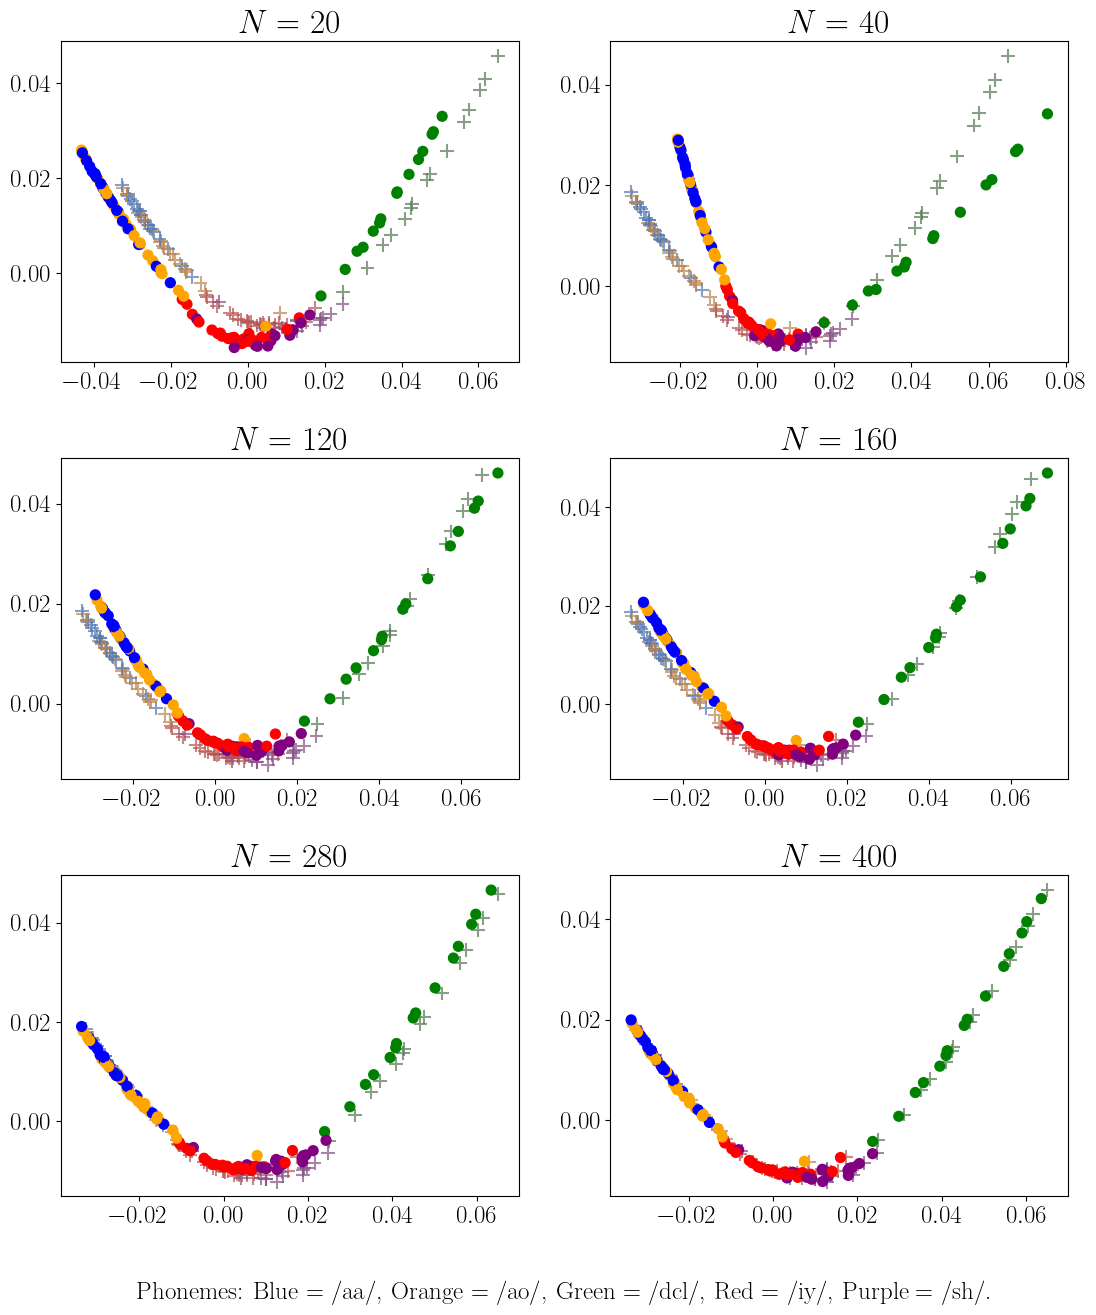

In [17]:

# Divide the training dataset into equal pieces
# N = 400 implies training over the whole training set
split_indices = [10, 20, 40, 120, 160, 240, 300, 400]
split_indices = [20, 40, 120, 160, 280, 400]


# fig, axs = plt.subplots(4, 2, figsize=(12, 15))
# plt.subplots_adjust(wspace=0.3, hspace=0.5)
fig, axs = plt.subplots(3, 2, figsize=(13, 15))
plt.subplots_adjust(wspace=0.2, hspace=0.3)
axs = axs.ravel()
k = 0


for index in split_indices:
    subset_indices = indices[:int(index)]
    fd_train_subset = fd_train[subset_indices]
    y_train_subset = y_train[subset_indices]
    
    fdm = FDM(alpha=optimum_alpha, kernel=Gaussian(length_scale=length_scale))

    train_subset_embedding = fdm.fit_transform(fd_train_subset)
    test_embedding = fdm.fit(fd_train_subset).transform(fd_test)

    # axs[1].set_title('Predicted diffusion coordinates of the test set.')
    axs[k].scatter(
        # test_true_embedding[:, 0], test_true_embedding[:, 1],
        # np.sqrt(500/index) * test_true_embedding[:, 0], np.sqrt(500/index) * test_true_embedding[:, 1],
        test_true_embedding[:, 0], test_true_embedding[:, 1],
        c=y_test, cmap=dark_cmap, alpha=0.7, marker ="+", s=100,
    )
    axs[k].scatter(
        np.sqrt(index/500) * test_embedding[:, 0], np.sqrt(index/500) * test_embedding[:, 1],
        c=y_test, cmap=cmap, s = 50,
    )
    axs[k].tick_params(axis='both', which='major', labelsize=fs)
    axs[k].set_title("$N =" + str(index) + "$", fontsize=24)
    k = k + 1
plt.text(-0.1, -0.3, 'Phonemes: Blue = /aa/, Orange = /ao/, Green = /dcl/, Red = /iy/, Purple = /sh/.',
         ha='center', va='center', fontsize=fs, transform=plt.gca().transAxes)
plt.show()